<font color=darkblue> 

## Описание задачи
___
    
### Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
### Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
### Необходимо построить модель с предельно большим значением F1-меры. 

## Описание данных

### Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

### Целевой признак

- Exited — факт ухода клиента

## Вызываю библиотеки

In [1]:
import pandas as pd
import itertools as itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

<font color=darkblue> 
# Подготовка данных

### Открываю датасет

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Проверю типы

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Вывод

- Пропуски в Tenure.
- Типы данных приведены.
- Используется верхний регистр.
- Присутствуют лишние для модели данные (RowNumber, Surname)


<font color=blue> 
# Подготовка дата сетов

### Что делаю

- Сброшу лишнее.
- Приведу к нижнему регистру.
- Проверю корреляцию.
- Кодирую признаки.
- Масштабирую признаки.
- Проверю баланс классов.
- Удалю пропуски, они могут повлиять на точность обучения модели.
- Разделю исходные данные на обучающую, валидационную и тестовую выборки.

### Уберу лишнее

In [5]:
churn = churn.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

### Проверю корреляцию

In [6]:
churn.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


#### Корреляция между exited и tenure отрицательная и низкая, равная -0.016761. Сильных зависимостей по другим параметрам тоже нет. Можно удалить пропуски в tenure.

In [7]:
churn = churn.dropna()

### Распределение коррелирующих признаков

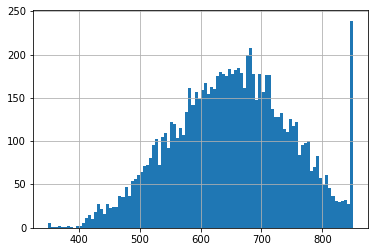

In [8]:
churn['CreditScore'].hist(bins = 100)

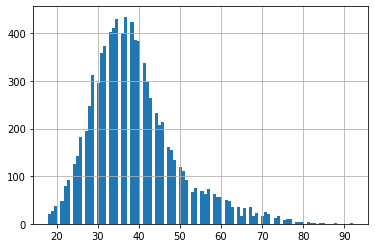

In [9]:
churn['Age'].hist(bins = 100)

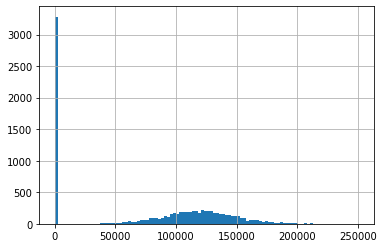

In [10]:
churn['Balance'].hist(bins = 100)

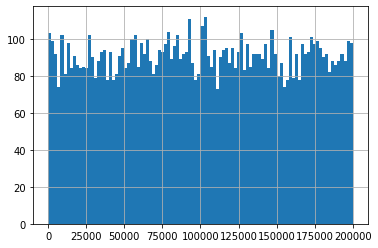

In [11]:
churn['EstimatedSalary'].hist(bins = 100)

### Проверю баланс классов

In [12]:
churn['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

### Кодирую признаки

In [13]:
churn = pd.get_dummies(churn)
churn = churn.drop(['Gender_Male'], axis=1)

### Привожу к нижнему регистру

In [14]:
churn.columns = churn.columns.str.lower()

In [15]:
churn

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_france,geography_germany,geography_spain,gender_female
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.0,0.00,2,0,0,167773.55,0,1,0,0,1
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,0
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,0
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,1


## Вывод

- Есть выбросы по балансу и по очкам кредитной истории, обучу с ними, но если качество будет падать, то удалю их.
- Баланс классов необходимо корректировать.

<font color=blue> 
# Обучение моделей

### Получу обучающую выборку в 60 процентов

In [16]:
churn_train, churn_test_valid = train_test_split(churn, test_size=0.4, random_state=12345)

### Получу тестовую и валидационную выборку в 20 процентов каждая

In [17]:
churn_test, churn_valid = train_test_split(churn_test_valid, test_size=0.5, random_state=12345)

### Параметры выборок

In [18]:
print('Dataset:', len(churn),
      'Осовная выборка:', len(churn_train),
      'Тестовая выборка:', len(churn_test), 
      'Валидационная выборка:', len(churn_valid))

Dataset: 9091 Осовная выборка: 5454 Тестовая выборка: 1818 Валидационная выборка: 1819


In [19]:
features_train = churn_train.drop(['exited'], axis=1)
target_train = churn_train['exited']

In [20]:
features_valid = churn_valid.drop(['exited'], axis=1)
target_valid = churn_valid['exited']

In [21]:
features_test = churn_test.drop(['exited'], axis=1)
target_test = churn_test['exited']

### Кодирую признаки

In [22]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary', 'tenure']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

In [23]:
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [24]:
features_test[numeric] = scaler.transform(features_test[numeric])

<font color=blue> 
# Построение моделей

<font color=red> 
## Случайный лес

### Подберу параметры

In [25]:
params_rf = {'max_depth':   [x for x in range (1,20)], 
             'n_estimators':[x for x in range (2,40)]
         }

In [26]:
feature_grid = pd.concat([features_train, features_valid], ignore_index=True)

In [27]:
target_grid = pd.concat([target_train, target_valid], ignore_index=True)

In [28]:
grid_forest = GridSearchCV(RandomForestClassifier(), params_rf, refit = True, cv = 5, n_jobs=-1)

In [29]:
grid_forest.fit(feature_grid, target_grid)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [30]:
grid_forest.best_params_

{'max_depth': 11, 'n_estimators': 33}

In [31]:
grid_forest.best_score_

0.8645675787157981

### На основании лучших параметров обучу модель

In [32]:
model_forest_grid = RandomForestClassifier(random_state=12345, n_estimators= 38,
                                           max_depth=16, n_jobs=-1).fit(features_train, target_train)

In [33]:
model_forest_grid__predict = model_forest_grid.predict(features_valid)

### Точность модели

In [34]:
accuracy_score(target_valid, model_forest_grid__predict)

0.8647608576140736

### f1 Метрика

In [35]:
f1_score(target_valid, model_forest_grid__predict)

0.5622775800711745

### AUC-ROC

In [36]:
def roc_auc (model, target):
    predict = model.predict_proba(features_valid)
    score = roc_auc_score(target, predict[:, 1])
    return score

In [37]:
roc_auc(model_forest_grid, target_valid)

0.8497044256581042

In [38]:
def curve(model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)


    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()   

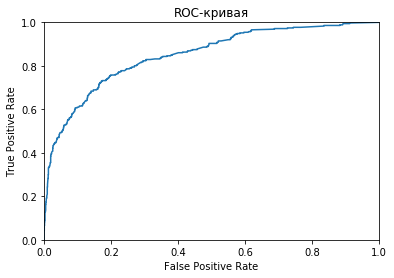

In [39]:
curve(model_forest_grid)

## Увеличу выборку положительных ответов

In [40]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [41]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Проверю баланс классов

In [42]:
target_upsampled.value_counts()

1    4504
0    4328
Name: exited, dtype: int64

### На основании лучших параметров дообучу модель

In [43]:
model_forest_shuffle = RandomForestClassifier(random_state=12345, n_estimators= 36,
                                           max_depth=18, n_jobs=-1).fit(features_upsampled, target_upsampled)

In [44]:
model_forest_shuffle_predict = model_forest_shuffle.predict(features_valid)

### Точность модели

In [45]:
accuracy_score(target_valid,  model_forest_shuffle_predict)

0.8576140736668499

### F1 Метрика

In [46]:
f1_score(target_valid, model_forest_shuffle_predict)

0.6057838660578386

### AUC-ROC

In [47]:
roc_auc(model_forest_shuffle, target_valid)

0.8363570025695367

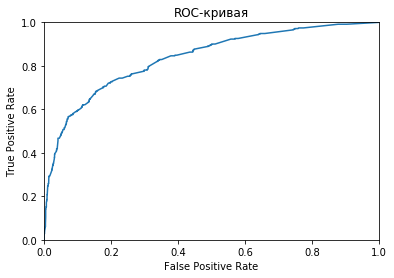

In [48]:
curve(model_forest_shuffle)

## Уменьшу выборку отрицательных ответов

In [49]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
   
    return features_downsampled, target_downsampled

In [50]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

### Проверю баланс классов

In [51]:
target_downsampled.value_counts()

1    1126
0    1082
Name: exited, dtype: int64

### На основании лучших параметров и уменьшинной выборке , дообучу модель

In [52]:
model_forest_downsampled = RandomForestClassifier(random_state=12345, n_estimators= 36,
                                           max_depth=18, n_jobs=-1).fit(features_downsampled, target_downsampled)

In [53]:
model_forest_downsampled = RandomForestClassifier(random_state=12345, n_estimators= 36,
                                           max_depth=18, n_jobs=-1).fit(features_downsampled, target_downsampled)

### Точность модели

In [54]:
accuracy_score(target_valid,  model_forest_downsampled_predict)

0.7669048927982408

### F1 Метрика

In [55]:
f1_score(target_valid, model_forest_downsampled_predict)

0.5536842105263157

### AUC-ROC

In [56]:
roc_auc(model_forest_downsampled, target_valid)

0.843133088024096

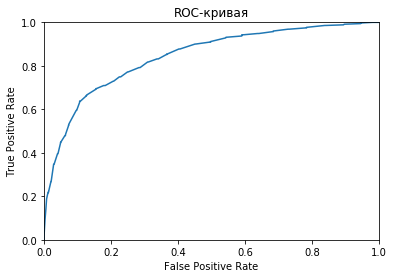

In [57]:
curve(model_forest_downsampled)

## Промежуточный вывод:
- Уменьшение семпла приводит к падению метрик модели.

## Задам веса классам

In [58]:
model_forest_weight = RandomForestClassifier(random_state=12345, n_estimators= 36,
                                           max_depth=18, n_jobs=-1, 
                                           class_weight='balanced').fit(features_downsampled, 
                                                                        target_downsampled)

In [59]:
model_forest_weight_predict = model_forest_downsampled.predict(features_valid)

### Точность модели

In [60]:
accuracy_score(target_valid,  model_forest_weight_predict)

0.7669048927982408

### F1 Метрика

In [61]:
f1_score(target_valid, model_forest_weight_predict)

0.5536842105263157

### AUC-ROC

In [62]:
roc_auc(model_forest_weight, target_valid)

0.8336322069292097

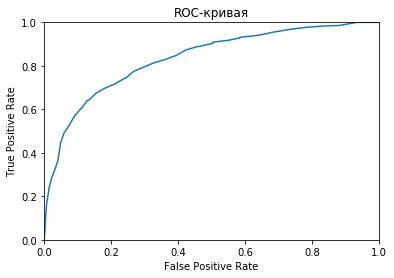

In [63]:
curve(model_forest_weight)

## Промежуточный вывод:
- Модель с приданием веса редковстречающимся классам, ожидаемо близка по метрикам к модели по уменьшенному семплу и также уступает увеличенному семплу.

<font color=red> 
## Градиентный бустинг (на увеличенном семпле)

In [64]:
gradient_model = GradientBoostingClassifier(random_state=12345).fit(features_upsampled, target_upsampled)
gradient_model_predict = gradient_model.predict(features_valid)

### Точность модели

In [65]:
accuracy_score(target_valid, gradient_model_predict)

0.7976910390324354

### F1 Метрика

In [66]:
f1_score(target_valid, gradient_model_predict)

0.5964912280701754

### AUC-ROC

In [67]:
roc_auc(gradient_model, target_valid)

0.8717512051980716

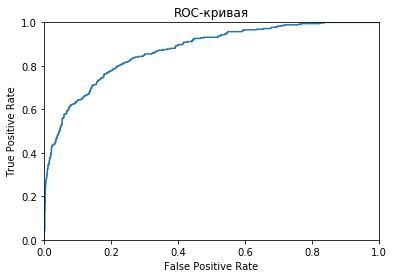

In [68]:
curve(gradient_model)

<font color=red> 
## Логистическая регрессия

#### Обучу модель на изначальных данных

In [69]:
model_logistic = LogisticRegression(random_state=12345, solver='liblinear').fit(features_train, target_train)

In [70]:
model_logistic_predict = model_logistic.predict(features_valid)

### Точность модели

In [71]:
model_logistic.score(features_train, target_train)

0.8050971763843051

In [72]:
accuracy_score(target_valid, model_logistic_predict)

0.8257284222100055

### F1 Метрика

In [73]:
f1_score(target_valid,  model_logistic_predict)

0.32119914346895073

### AUC-ROC

In [74]:
roc_auc(model_logistic, target_valid)

0.7809314764355637

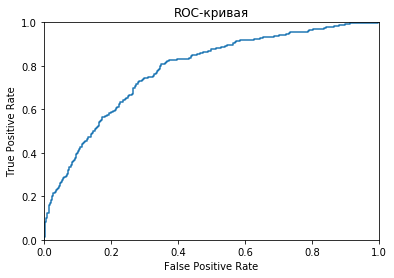

In [75]:
curve(model_logistic)

## Обучу модель на обогащенных данных

In [76]:
model_logistic_add = LogisticRegression(random_state=12345, solver='liblinear', 
                                                                        class_weight='balanced').fit(features_upsampled, target_upsampled)

In [77]:
model_logistic_add_predict = model_logistic_add.predict(features_valid)

### Точность модели

In [78]:
model_logistic_add.score(features_train, target_train)

0.7097543087642098

In [79]:
accuracy_score(target_valid, model_logistic_add_predict)

0.7317207256734469

### F1 Метрика

In [80]:
f1_score(target_valid, model_logistic_add_predict)

0.5030549898167006

### AUC-ROC

In [81]:
roc_auc(model_logistic_add, target_valid)

0.7817368825543213

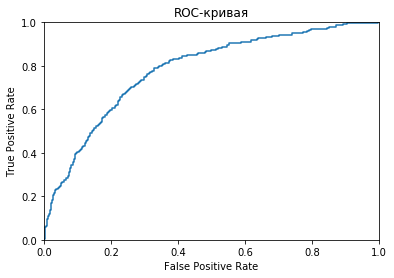

In [82]:
curve(model_logistic_add)

## Проверка на адекватность

In [83]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_valid, target_valid)

0.8070368334249588

In [84]:
dummy_clf.score(features_test, target_test)

0.7926292629262927

<font color=kblue> 
# Тестирование моделей

<font color=red> 
## Модель случайного леса

In [85]:
model_forest_shuffle = RandomForestClassifier(random_state=12345, n_estimators= 36,
                                           max_depth=18, n_jobs=-1).fit(features_upsampled, target_upsampled)

In [86]:
model_forest_shuffle_test = model_forest_shuffle.predict(features_test)

### Точность модели

In [87]:
accuracy_score(target_test, model_forest_shuffle_test)

0.8613861386138614

### F1 Метрика

In [88]:
f1_score(target_test, model_forest_shuffle_test)

0.631578947368421

### AUC-ROC

In [89]:
def roc_auc (model, target):
    predict = model.predict_proba(features_test)
    score = roc_auc_score(target, predict[:, 1])
    return score

In [90]:
roc_auc(model_forest_shuffle, target_test)

0.8561555580507937

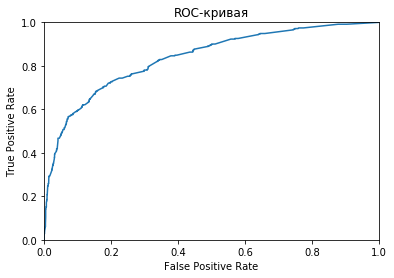

In [91]:
curve(model_forest_shuffle)

<font color=red> 
## Модель градиентного спуска

In [92]:
gradient_model = GradientBoostingClassifier(random_state=12345).fit(features_upsampled, target_upsampled)
gradient_model_predict = gradient_model.predict(features_test)

### Точность модели

In [93]:
accuracy_score(target_test, gradient_model_predict)

0.7920792079207921

### F1 Метрика

In [94]:
f1_score(target_test, gradient_model_predict)

0.60625

### AUC-ROC

In [95]:
roc_auc(gradient_model, target_test)

0.8708300123146135

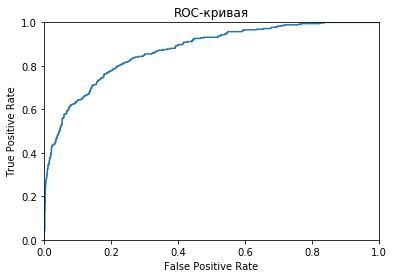

In [96]:
curve(gradient_model)

<font color=red> 
## Модель логистической регрессии

In [97]:
model_logistic_add = LogisticRegression(random_state=12345, solver='liblinear').fit(features_upsampled, target_upsampled)

In [98]:
model_logistic_add_test = model_logistic_add.predict(features_test)

### Точность модели

In [99]:
model_logistic_add.score(features_test, target_test)

0.7013201320132013

### F1 Метрика

In [100]:
f1_score(target_test, model_logistic_add_test)

0.5085972850678734

### AUC-ROC

In [101]:
roc_auc(model_logistic_add, target_test)

0.7778841321878963

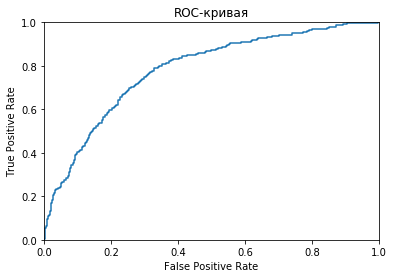

In [102]:
curve(model_logistic_add)

## Вывод

### Самые высокие парметры F1 = 0.632 и AUC-ROC = 0.856, показала модель случайного леса с гиперпараметрами n_estimators= 38, max_depth=18. Ее можно принять как рабочую.
### Логистическая регрессия не прошла тест на адекватность